In [1]:
from jetstream_hugo.data import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.plots import *
%load_ext autoreload
%autoreload 2

In [2]:
from dynlib.detect import jetaxis
from dynlib import dynfor
dynfor.config.jetint_thres = 1.e-11

In [5]:
ds = xr.open_dataset(f"/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/results/5/ds.nc", chunks="auto").isel(time=slice(1200)).load()

In [6]:
from itertools import pairwise


def find_jets_spensberger(ds, no: int = 4000, nf: int = 100):
    ds = coarsen_da(ds, 1.5)
    dx, dy = compute_dx_dy(ds)
    lon_da = ds.lon.assign_coords(lon=("lon", np.arange(len(ds.lon))))
    lat_da = ds.lat.assign_coords(lat=("lat", np.arange(len(ds.lat))))
    u_smo = smooth(ds["u"], smooth_map={"lon+lat": ("fft", 0.5)})
    v_smo = smooth(ds["v"], smooth_map={"lon+lat": ("fft", 0.5)})
    all_points, all_group_ends = jetaxis(no, nf, u_smo.values, v_smo.values, dx, dy)
    jets = []
    for points, group_ends in zip(all_points, all_group_ends):
        end = np.argmax(group_ends[1:] == 0) + 1
        if end == 1:
            continue
        jets.append([])
        x, y, s = points.T
        x = lon_da.interp(lon=x, method="linear").values
        y = lat_da.interp(lat=y, method="linear").values
        group = np.asarray([x, y, s]).T
        for istart, iend in pairwise(group_ends[:end].astype(int)):
            jets[-1].append(pd.DataFrame(group[istart:iend], columns=["lon", "lat", "s"]))
    return all_jets_to_one_df(jets, ds.time.values)

In [7]:
all_jets_spensberger = find_jets_spensberger(ds)

 preparing
all jets to one df


100%|██████████| 1200/1200 [00:02<00:00, 465.83it/s]


In [8]:
all_jets_one_df = find_all_jets(ds, wind_threshold=23, alignment_threshold=0.3, jet_threshold=1e8, mean_alignment_threshold=0.7, processes=12, chunksize=10)
all_jets_one_df = all_jets_to_one_df(all_jets_one_df, ds.time.values)

Finding all jets


100%|██████████| 1200/1200 [00:55<00:00, 21.62it/s]


all jets to one df


100%|██████████| 1200/1200 [00:01<00:00, 618.69it/s]


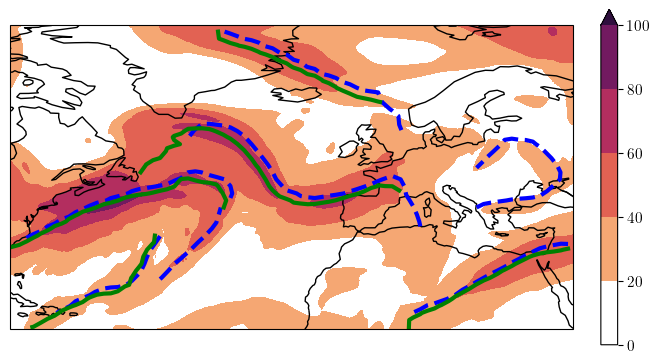

In [9]:
from jetstream_hugo.definitions import get_region
i = np.random.randint(0, ds["s"].shape[0])
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds["s"].isel(time=i)], cmap=colormaps.matter, transparify=1)
ax = clu.axes[0]
time = ds.time[i].values
colors = COLORS5

jets_spensberger = all_jets_spensberger.loc[time]
my_jets = all_jets_one_df.loc[time]

for jid, jet in jets_spensberger.groupby(level=0):
    i = int(jid[1:])
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, color="blue", linestyle="dashed", lw=3)
    
for jid, jet in my_jets.groupby(level=0):
    i = int(jid[1:])
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, color="green", linestyle="solid", lw=3)